# 🎵 Individual Assignment #2 — Add / Multiply / Synthesize!

**Course:** 22051 – *Signals and Linear Systems in Discrete Time*  
**Institution:** DTU Health Technology – Hearing Systems Section  
**Student:** *Yann [Your Last Name]*  
**Instructor:** *Bastian Epp*  
**Semester:** Fall 2025  

---

## 🎯 Project Overview

This assignment demonstrates the design and implementation of a **digital audio synthesizer** using *Discrete-Time Signal Processing* principles.

Over the course of this notebook, several key components of a synthesizer are implemented step by step:
1. **Oscillator Bank** – generation of sine, square, triangle, and sawtooth waves  
2. **ADSR Envelope Generator** – shaping amplitude over time (Attack–Decay–Sustain–Release)  
3. **Filter Section** – tone control via low-pass, high-pass, band-pass, and all-pass filters  
4. **Synthesis Stage** – combining, modulating, and sequencing signals to create final sounds  

Each stage is modular, allowing flexible experimentation and sound design.

---

## 🧩 How to Run

1. Open this notebook in **JupyterLab** or **VS Code Jupyter** environment.  
2. Run all cells sequentially from top to bottom.  
3. Each step will:
   - Generate and visualize signals,
   - Display time and frequency plots,
   - Optionally export `.wav` audio files to `output/sounds/`.

---

## 🧠 Learning Objective

The goal of this assignment is to:
- Understand how digital systems generate and manipulate sound,
- Explore the connection between **mathematical signal operations** and **perceptual audio effects**,  
- Build an intuitive understanding of **Discrete-Time Systems** through practical synthesis.

This project integrates core DSP topics — convolution, frequency response, and modulation — into a creative and audible outcome.



# Step 1 – Oscillator Bank : Sine, Square, Triangle & Sawtooth

**Goal:** Implement and explore basic waveform generators for a digital synthesizer.

**Components:**
- Sine wave
- Square wave
- Triangle wave
- Sawtooth wave

**Tasks:**
- Generate 1 s samples at 44.1 kHz.
- Plot short time windows (≈ 50 ms).
- Plot one-sided magnitude spectra in dB.
- Observe harmonic structures and explain their timbral differences.


In [1]:
import sys
sys.path.append("src")

from src.signal_generators import sine_wave, square_wave, triangle_wave, sawtooth_wave
from src.visualization import plot_time, plot_spectrum
from src.utils import FS, normalize_audio, save_wav

## Step 1.1 – Parameters

For testing we use:
- Sampling rate `fs = 44.1 kHz`
- Duration `1 s`
- Frequency `f0 = 220 Hz` (A3)  
  This leaves enough headroom below Nyquist (22 kHz) to avoid aliasing.


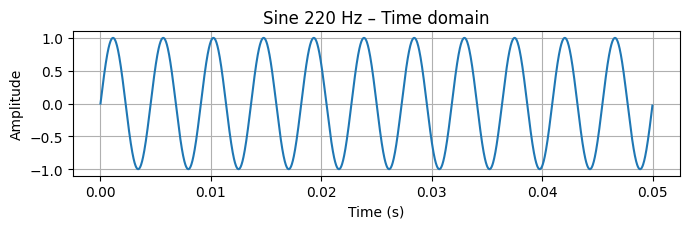

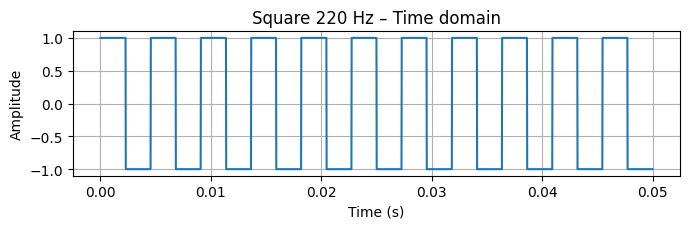

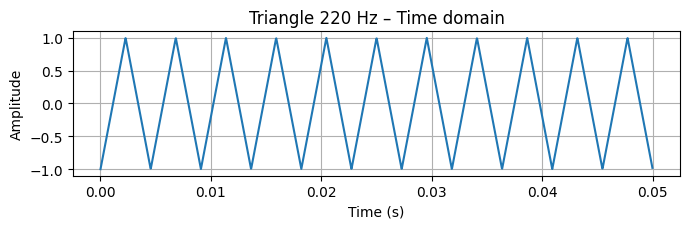

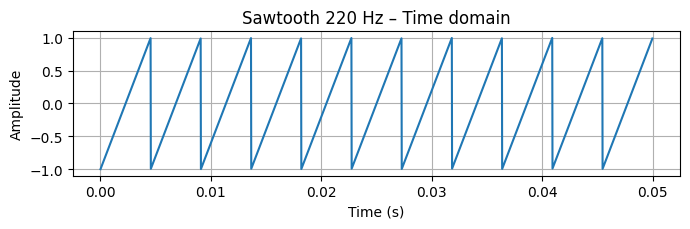

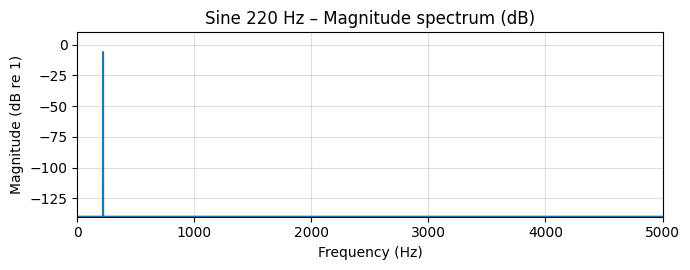

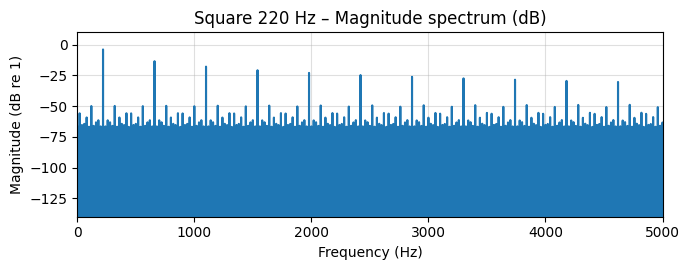

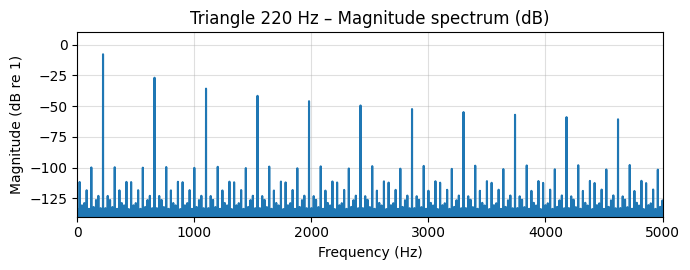

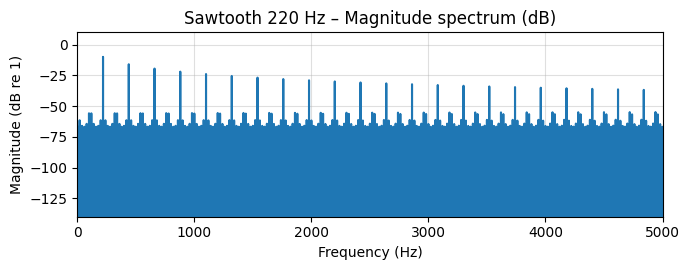

In [2]:
fs = FS
f0 = 220.0
dur_demo = 1.0  # seconds
view_ms = 0.05  # 50 ms for time plots

x_sin = sine_wave(f0, dur_demo, amp=1.0, fs=fs)
x_sq  = square_wave(f0, dur_demo, amp=1.0, fs=fs)
x_tri = triangle_wave(f0, dur_demo, amp=1.0, fs=fs)
x_saw = sawtooth_wave(f0, dur_demo, amp=1.0, fs=fs)

# ---- Time domain ----
plot_time(x_sin, fs, tmax=view_ms, title="Sine 220 Hz – Time domain")
plot_time(x_sq,  fs, tmax=view_ms, title="Square 220 Hz – Time domain")
plot_time(x_tri, fs, tmax=view_ms, title="Triangle 220 Hz – Time domain")
plot_time(x_saw, fs, tmax=view_ms, title="Sawtooth 220 Hz – Time domain")

# ---- Frequency domain ----
xlim = 5000  # Hz
plot_spectrum(x_sin, fs, title="Sine 220 Hz – Magnitude spectrum (dB)", xlim_hz=xlim)
plot_spectrum(x_sq,  fs, title="Square 220 Hz – Magnitude spectrum (dB)", xlim_hz=xlim)
plot_spectrum(x_tri, fs, title="Triangle 220 Hz – Magnitude spectrum (dB)", xlim_hz=xlim)
plot_spectrum(x_saw, fs, title="Sawtooth 220 Hz – Magnitude spectrum (dB)", xlim_hz=xlim)

# ---- Optional: export audio ----
from pathlib import Path
Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step1_sine.wav",    normalize_audio(x_sin), fs)
save_wav("output/sounds/step1_square.wav",  normalize_audio(x_sq),  fs)
save_wav("output/sounds/step1_triangle.wav",normalize_audio(x_tri), fs)
save_wav("output/sounds/step1_sawtooth.wav",normalize_audio(x_saw), fs)


## Observations

| Waveform | Harmonics | Amplitude Decay | Perceived Timbre |
|-----------|------------|----------------|------------------|
| **Sine** | Fundamental only | –  | Pure tone |
| **Square** | Odd harmonics (3f, 5f, …) | 1/n  | Bright, brassy |
| **Triangle** | Odd harmonics | 1/n²  | Softer than square |
| **Sawtooth** | All harmonics (2f, 3f, …) | 1/n  | Very bright/buzzy |

These spectra explain why different basic waveforms already have distinct timbres.  
Later steps (ADSR envelope, filters, modulations) will shape these raw sounds into richer tones.


# Step 2 – ADSR Envelope Generator

**Goal:** Implement an *Attack–Decay–Sustain–Release* (ADSR) envelope and apply it to a waveform.  

**Concept:**
- **Attack:** rise from 0 → 1
- **Decay:** drop to sustain level
- **Sustain:** constant amplitude plateau
- **Release:** fall back to 0

The envelope shapes the amplitude of a waveform over time, giving it a more natural dynamic behaviour — from percussive hits to long pads.


In [3]:
from src.envelope_adsr import adsr_envelope, apply_envelope
from src.signal_generators import sine_wave
from src.visualization import plot_time, plot_spectrum
from src.utils import FS, normalize_audio, save_wav


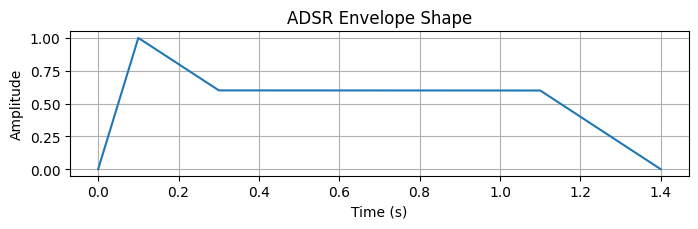

In [4]:
# Envelope parameters
attack = 0.1
decay = 0.2
sustain_level = 0.6
sustain_time = 0.8
release = 0.3

# Generate envelope
env, t_env = adsr_envelope(attack, decay, sustain_level, sustain_time, release, fs=FS)

# Plot envelope shape
plot_time(env, FS, tmax=t_env[-1], title="ADSR Envelope Shape")


## Step 2.1 – Applying the Envelope

We apply the ADSR envelope to a 220 Hz sine wave to observe:
- the **time-domain shaping**
- the **spectral broadening** introduced by the amplitude modulation.


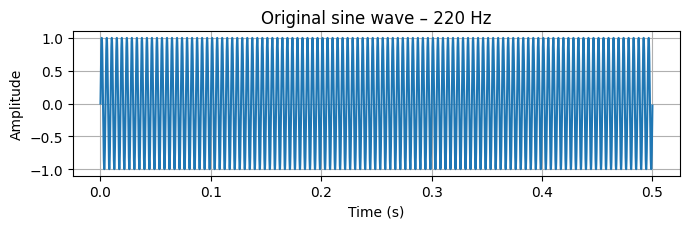

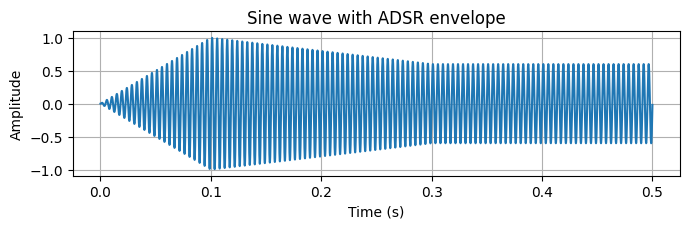

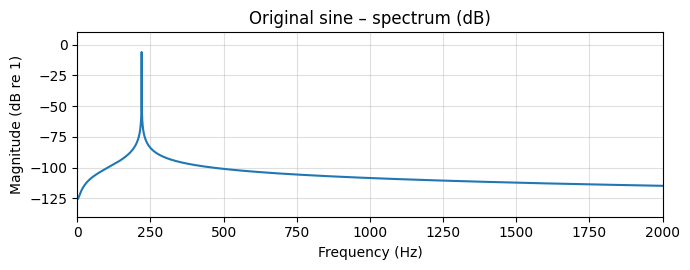

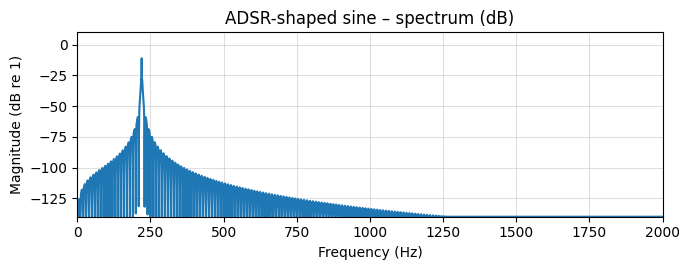

In [5]:
# Create sine wave with same duration as envelope
signal_len = len(env) / FS
x = sine_wave(220, duration=signal_len, fs=FS)

# Apply envelope
x_env = apply_envelope(x, env)

# Plot before/after
plot_time(x, FS, tmax=0.5, title="Original sine wave – 220 Hz")
plot_time(x_env, FS, tmax=0.5, title="Sine wave with ADSR envelope")

# Compare spectra
plot_spectrum(x, FS, title="Original sine – spectrum (dB)", xlim_hz=2000)
plot_spectrum(x_env, FS, title="ADSR-shaped sine – spectrum (dB)", xlim_hz=2000)

# Optional: save output
from pathlib import Path
Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step2_sine_adsr.wav", normalize_audio(x_env), FS)


## Observations

- The ADSR envelope modifies only **amplitude**, not frequency content.
- The **attack** defines how fast the sound reaches its maximum.
- The **decay** and **sustain** set the body of the sound.
- The **release** controls how smoothly it fades out.

A faster attack and short release create **percussive** sounds (like drums or plucks).  
Longer attack and release times yield **pad-like** or **ambient** tones.

This mechanism will be combined later with filters and modulation to create more complex synthesized sounds.


# Step 3 – Filter Section

**Goal:** Implement digital filters to shape the spectrum of generated signals.

Filters allow us to control the **frequency content** of a sound:
- **Low-pass:** keeps low frequencies, removes highs.
- **High-pass:** keeps highs, removes lows.
- **Band-pass:** isolates a frequency range.
- **All-pass:** keeps magnitude constant, changes phase.

We use 4th-order Butterworth filters for smooth frequency response.


In [6]:
from src.filters import design_filter, apply_filter, freq_response
from src.signal_generators import sawtooth_wave
from src.visualization import plot_time, plot_spectrum
from src.utils import FS, normalize_audio, save_wav
import matplotlib.pyplot as plt


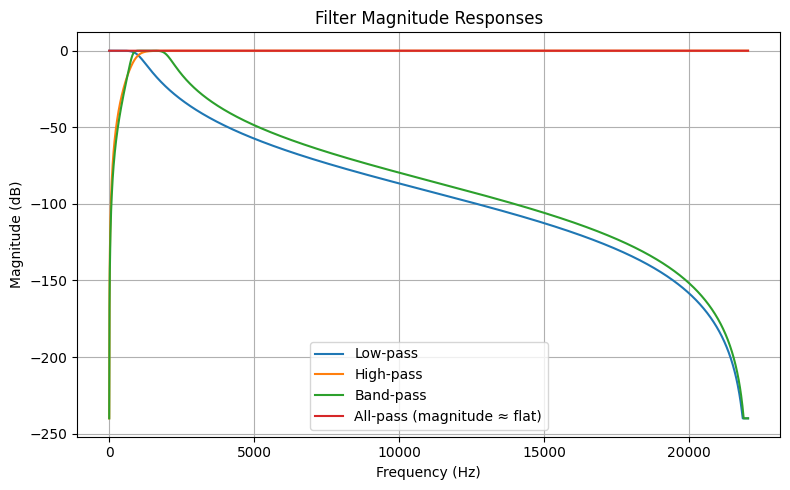

In [7]:
# Define filter specs
fs = FS
order = 4

# Design different filters
b_lp, a_lp = design_filter('lowpass', cutoff=1000, fs=fs, order=order)
b_hp, a_hp = design_filter('highpass', cutoff=1000, fs=fs, order=order)
b_bp, a_bp = design_filter('bandpass', band=(800, 2000), fs=fs, order=order)
b_ap, a_ap = design_filter('allpass', cutoff=1500, fs=fs, order=order)

# Compute frequency responses
w_lp, mag_lp, _ = freq_response(b_lp, a_lp, fs)
w_hp, mag_hp, _ = freq_response(b_hp, a_hp, fs)
w_bp, mag_bp, _ = freq_response(b_bp, a_bp, fs)
w_ap, mag_ap, _ = freq_response(b_ap, a_ap, fs)

# Plot frequency responses
plt.figure(figsize=(8, 5))
plt.plot(w_lp, mag_lp, label="Low-pass")
plt.plot(w_hp, mag_hp, label="High-pass")
plt.plot(w_bp, mag_bp, label="Band-pass")
plt.plot(w_ap, mag_ap, label="All-pass (magnitude ≈ flat)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Filter Magnitude Responses")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Step 3.1 – Filtering a waveform

We now apply each filter to a **sawtooth wave**.  
This waveform is rich in harmonics, so it’s ideal for testing frequency shaping.


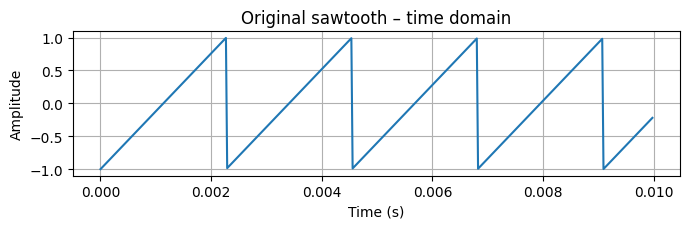

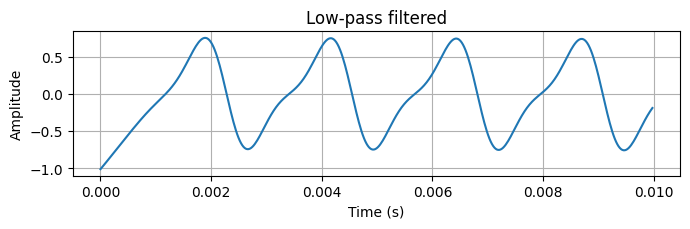

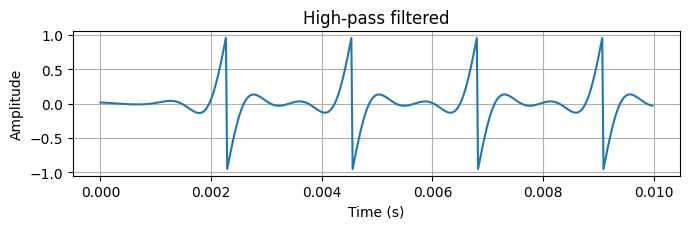

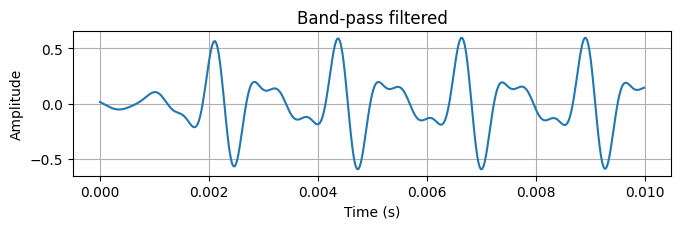

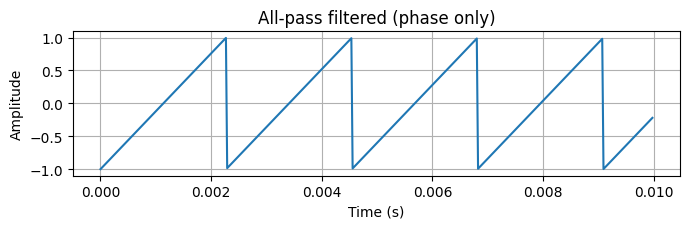

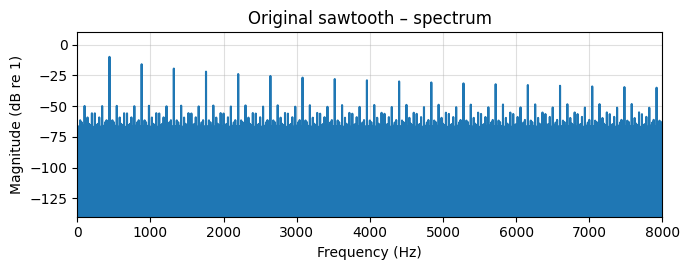

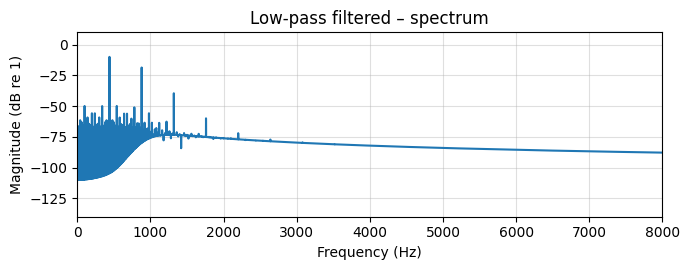

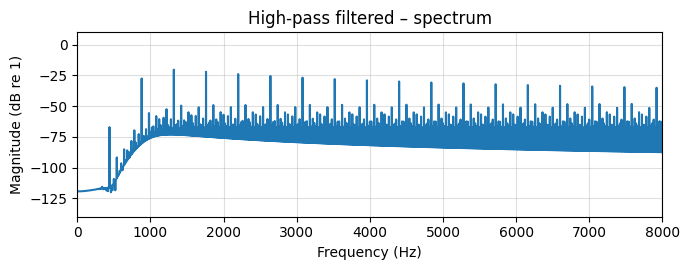

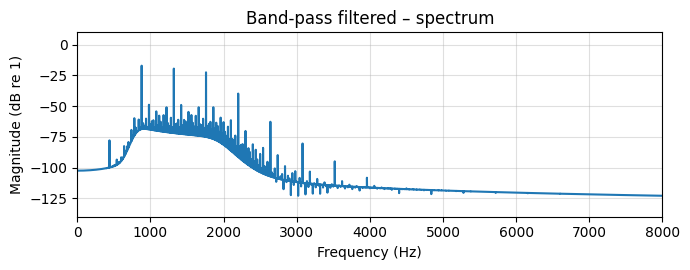

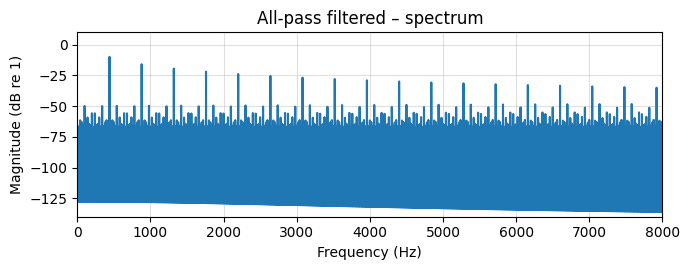

In [8]:
f0 = 440.0  # A4
dur = 1.0
x = sawtooth_wave(f0, duration=dur, fs=fs)

# Apply each filter
x_lp = apply_filter(x, b_lp, a_lp)
x_hp = apply_filter(x, b_hp, a_hp)
x_bp = apply_filter(x, b_bp, a_bp)
x_ap = apply_filter(x, b_ap, a_ap)

# Compare time-domain signals
plot_time(x, fs, tmax=0.01, title="Original sawtooth – time domain")
plot_time(x_lp, fs, tmax=0.01, title="Low-pass filtered")
plot_time(x_hp, fs, tmax=0.01, title="High-pass filtered")
plot_time(x_bp, fs, tmax=0.01, title="Band-pass filtered")
plot_time(x_ap, fs, tmax=0.01, title="All-pass filtered (phase only)")

# Compare frequency spectra
xlim = 8000
plot_spectrum(x, fs, title="Original sawtooth – spectrum", xlim_hz=xlim)
plot_spectrum(x_lp, fs, title="Low-pass filtered – spectrum", xlim_hz=xlim)
plot_spectrum(x_hp, fs, title="High-pass filtered – spectrum", xlim_hz=xlim)
plot_spectrum(x_bp, fs, title="Band-pass filtered – spectrum", xlim_hz=xlim)
plot_spectrum(x_ap, fs, title="All-pass filtered – spectrum", xlim_hz=xlim)

# Optional: save results
from pathlib import Path
Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step3_sawtooth_lp.wav", normalize_audio(x_lp), fs)
save_wav("output/sounds/step3_sawtooth_hp.wav", normalize_audio(x_hp), fs)
save_wav("output/sounds/step3_sawtooth_bp.wav", normalize_audio(x_bp), fs)
save_wav("output/sounds/step3_sawtooth_ap.wav", normalize_audio(x_ap), fs)


## Observations

| Filter | Description | Effect on Spectrum | Sound Character |
|---------|--------------|--------------------|------------------|
| **Low-pass** | Attenuates high harmonics | Smooth, muffled | Warm or bassy |
| **High-pass** | Removes low frequencies | Thin, bright | Metallic or sharp |
| **Band-pass** | Isolates middle range | Resonant, “nasal” | Focused tone |
| **All-pass** | Keeps magnitude flat, changes phase | Phase shift only | Used for phasing/flanging effects |

The **all-pass** filter is interesting because it changes the phase relationship between harmonics — producing subtle interference when mixed with the original signal (a typical trick in *phaser* effects).


# Step 4 – Add, Multiply, and Synthesize!

**Goal:** Combine all previous building blocks into a complete digital synthesizer chain.  

We now:
1. Generate multiple oscillators (sine, square, sawtooth, etc.)
2. Apply amplitude envelopes (ADSR)
3. Filter the signal (tone shaping)
4. Combine signals through addition and multiplication
5. Create a final sound effect!

We can now design different sounds such as a *techno kick*, *laser*, *bass*, *ambient pad*, or *explosion*.

In [9]:
from src.synth_utils import synthesize_sound, mix_signals, multiply_signals
from src.visualization import plot_time, plot_spectrum
from src.utils import save_wav, FS
import numpy as np
from pathlib import Path


Generating: techno


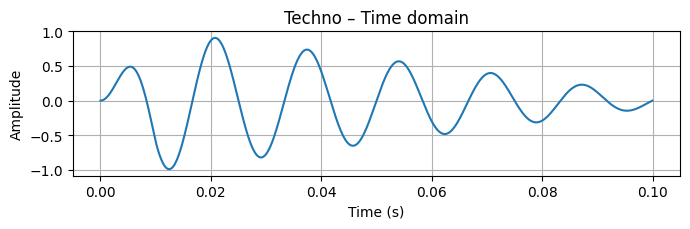

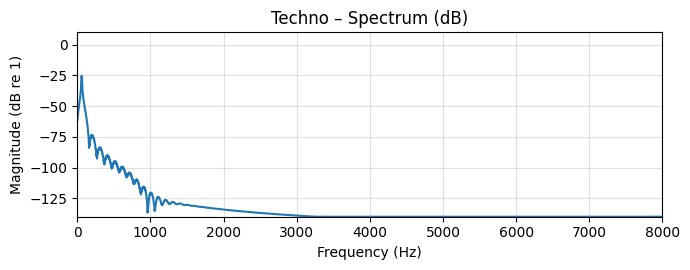

Generating: laser


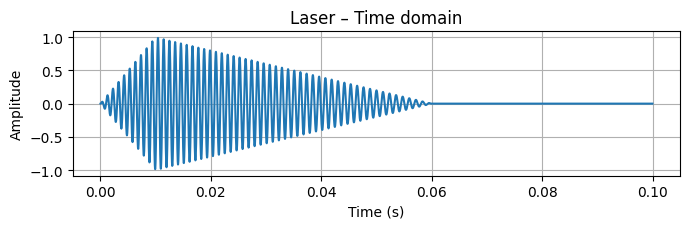

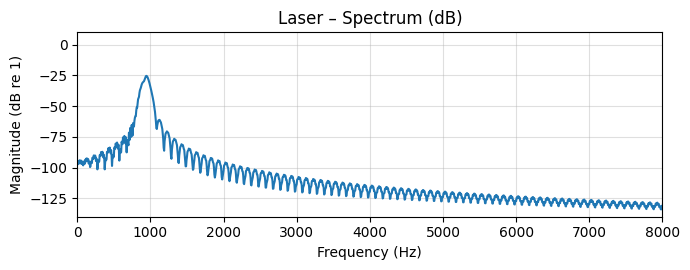

Generating: bass


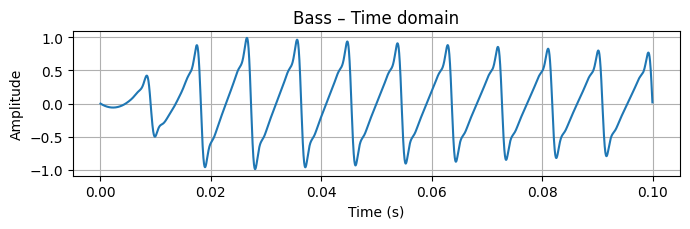

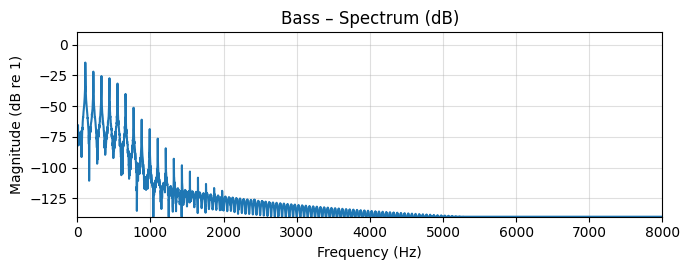

Generating: explosion


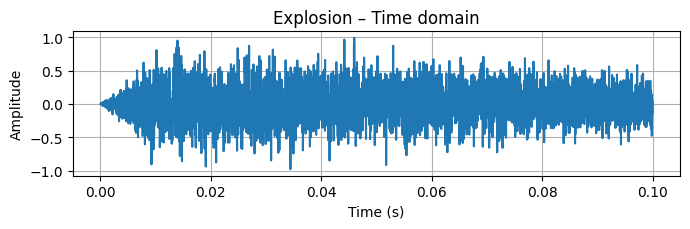

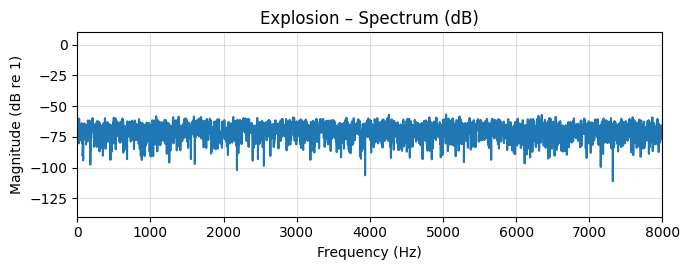

Generating: ambient


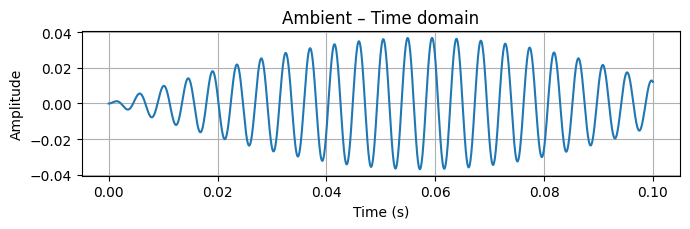

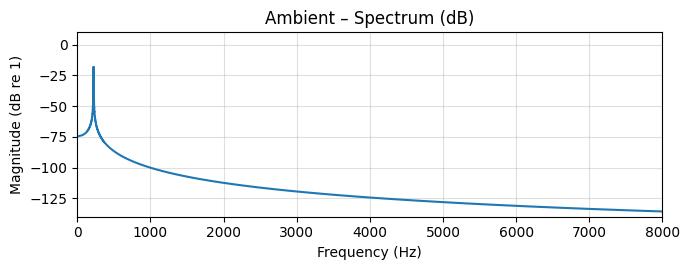

In [10]:
Path("output/sounds").mkdir(parents=True, exist_ok=True)

# Generate several preset sounds
sounds = ["techno", "laser", "bass", "explosion", "ambient"]

for s in sounds:
    print(f"Generating: {s}")
    y = synthesize_sound(s, fs=FS)
    save_wav(f"output/sounds/step4_{s}.wav", y, FS)
    plot_time(y, FS, tmax=0.1, title=f"{s.capitalize()} – Time domain")
    plot_spectrum(y, FS, title=f"{s.capitalize()} – Spectrum (dB)", xlim_hz=8000)


## Step 4.1 – Combining sounds

We can **add** signals to mix different textures  
or **multiply** them to perform amplitude modulation.

This is a simple way to create more complex and evolving timbres.


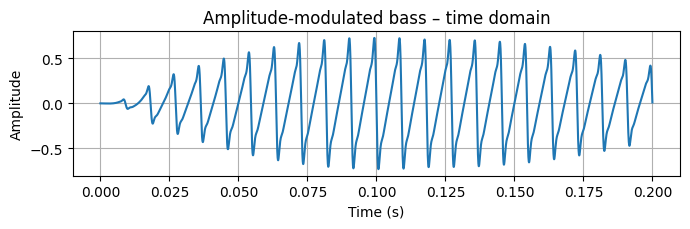

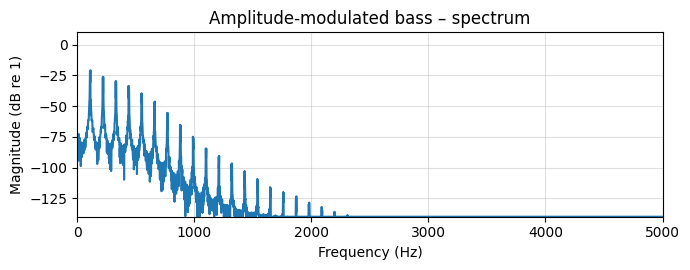

In [11]:
# Example: Multiply a bass with a low-frequency sine (modulation)
bass = synthesize_sound("bass", fs=FS)
mod = np.sin(2 * np.pi * 2 * np.arange(len(bass)) / FS)  # 2 Hz modulation
modulated = multiply_signals(bass, mod)

# Example: Add a laser and explosion together
laser = synthesize_sound("laser", fs=FS)
explosion = synthesize_sound("explosion", fs=FS)
mixed = mix_signals([laser, explosion], mode="concat")

# Save
save_wav("output/sounds/step4_modulated_bass.wav", modulated, FS)
save_wav("output/sounds/step4_laser_explosion_mix.wav", mixed, FS)

# Visualize
plot_time(modulated, FS, tmax=0.2, title="Amplitude-modulated bass – time domain")
plot_spectrum(modulated, FS, title="Amplitude-modulated bass – spectrum", xlim_hz=5000)


## Observations and Discussion

- **Addition (mixing)** creates richer spectra and layered textures.  
- **Multiplication (modulation)** produces sidebands and dynamic timbral variation.  
- Filters and envelopes allow control over the evolution and color of the sound.  

This complete chain is the digital equivalent of a **basic subtractive synthesizer**, 
combining oscillators, envelopes, and filters to shape sound creatively.  

🎧 The exported `.wav` files demonstrate how different synthesis techniques
lead to distinct sonic characters — from percussive hits to ambient pads.


# Step 5 – Final Sound Design and Discussion


In [12]:
from src.synth_utils import synthesize_sound, mix_signals
from src.utils import save_wav, FS
from pathlib import Path

Path("output/sounds").mkdir(parents=True, exist_ok=True)

# Create a short techno-like sequence (kick + bass + laser + explosion)
kick = synthesize_sound("techno", fs=FS)
bass = synthesize_sound("bass", fs=FS)
laser = synthesize_sound("laser", fs=FS)
explosion = synthesize_sound("explosion", fs=FS)

# Sequence: kick → bass → laser → explosion
track = mix_signals([kick, bass, laser, explosion], mode="concat")
save_wav("output/sounds/final_track.wav", track, FS)

## Explanation of the Final Sound

The final sound is a **synthetic techno-style sequence** consisting of four successive parts:
1. **Kick drum** – created with a 60 Hz sine wave, short envelope, and low-pass filter.  
   → Produces a deep thump with fast decay.
2. **Bass tone** – sawtooth waveform filtered at 600 Hz with a smooth ADSR envelope.  
   → Adds harmonic richness while remaining warm and rounded.
3. **Laser effect** – downward frequency sweep with a sharp envelope.  
   → Generates a short, bright, and dynamic sound typical of sci-fi lasers.
4. **Explosion** – filtered noise with an all-pass cascade and long release.  
   → Creates a wide and noisy texture with decaying amplitude.

By concatenating these elements, we obtain a short “techno” sequence showing all synthesis components in action:
- **Oscillators** provide the basic tonal content.
- **ADSR envelopes** shape their temporal dynamics.
- **Filters** sculpt the timbre and remove unwanted frequencies.
- **Addition/concatenation** combines multiple textures into a single sound.

The result demonstrates control over both **time** (via envelopes) and **frequency** (via filters), resulting in a perceptually rich and coherent synthesized sound.


## Reflections and Learning Outcome

This project guided the complete construction of a **digital subtractive synthesizer** using Python:
- Starting from pure waveform generation,
- Adding dynamic control via envelopes,
- Applying filters for spectral shaping,
- And finally combining signals to create original sounds.

Through this process, I learned:
- How the **time-domain operations** (envelopes, modulation) affect the perceived articulation,
- How **frequency-domain shaping** via filters changes the timbre,
- And how simple combinations of mathematical functions can create complex and expressive audio.

The code is modular and reusable: each component (oscillator, envelope, filter) can be tuned or extended to design entirely new instruments or effects.


---

🎶 **Final Output:** [`output/sounds/final_track.wav`](output/sounds/final_track.wav)

🧠 *The result combines synthesis, filtering, and modulation – a complete mini synthesizer built from scratch.*


In [13]:
# -------------------------------
# Step 5 – 30s track: "Ode to Joy"
# -------------------------------
import numpy as np
from src.utils import FS, save_wav, normalize_audio
from src.signal_generators import sine_wave, sawtooth_wave, triangle_wave
from src.envelope_adsr import adsr_envelope, apply_envelope
from src.filters import design_filter, apply_filter
from pathlib import Path

# --- Helpers ---
A4 = 440.0
NOTE_IDX = {'C':0,'C#':1,'Db':1,'D':2,'D#':3,'Eb':3,'E':4,'F':5,'F#':6,'Gb':6,'G':7,'G#':8,'Ab':8,'A':9,'A#':10,'Bb':10,'B':11}

def note_to_freq(name: str) -> float:
    """Convert note name like 'C4','F#3','Bb4' to Hz (A4=440)."""
    # split pitch class and octave
    if len(name) == 2:
        p, o = name[0], int(name[1])
        accidental = ''
    else:
        p, accidental, o = name[0], name[1], int(name[2])
        p = p + accidental
    n = NOTE_IDX[p] + 12*(o - 4) - 9  # semitones from A4
    return A4 * (2.0 ** (n/12))

def beats_to_seconds(beats, bpm):
    return 60.0 * beats / bpm

def add_to_buffer(buf, x, start_samp):
    end = min(len(buf), start_samp + len(x))
    if end > start_samp:
        buf[start_samp:end] += x[:(end - start_samp)]

# --- Simple instruments ---
def lead_synth(freq, dur, fs=FS):
    """Bright lead: sawtooth + gentle LPF + ADSR + light vibrato."""
    t = np.arange(int(dur*fs))/fs
    # mild vibrato
    vib = 0.25 * np.sin(2*np.pi*5*t)  # 5 Hz, ±0.25 semitones
    f_inst = freq * (2**(vib/12))
    x = sawtooth_wave(f_inst.mean(), duration=dur, fs=fs)  # coarse approx
    # short clickless attack
    env, _ = adsr_envelope(attack=0.01, decay=0.08, sustain_level=0.65, sustain_time=max(0.0, dur-0.20), release=0.11, fs=fs)
    x = apply_envelope(x, env)
    b, a = design_filter('lowpass', cutoff=3000, fs=fs, order=4)
    x = apply_filter(x, b, a)
    return normalize_audio(x)

def bass_synth(freq, dur, fs=FS):
    """Warm bass: triangle + LPF + ADSR."""
    x = triangle_wave(freq, duration=dur, fs=fs)
    b, a = design_filter('lowpass', cutoff=450, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.01, decay=0.12, sustain_level=0.7, sustain_time=max(0.0, dur-0.25), release=0.12, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def kick(dur=0.24, fs=FS):
    """Kick: decaying sine with quick pitch drop."""
    t = np.arange(int(dur*fs))/fs
    f_start, f_end = 90, 50
    f = f_start + (f_end - f_start) * (t/dur)
    x = np.sin(2*np.pi*np.cumsum(f)/fs)
    env, _ = adsr_envelope(attack=0.002, decay=0.15, sustain_level=0.0, sustain_time=0.0, release=0.07, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def snare(dur=0.20, fs=FS):
    """Snare: noise burst + band-pass + envelope."""
    noise = np.random.randn(int(dur*fs))
    b, a = design_filter('bandpass', band=(1500, 3500), fs=fs, order=2)
    x = apply_filter(noise, b, a)
    env, _ = adsr_envelope(attack=0.001, decay=0.12, sustain_level=0.0, sustain_time=0.0, release=0.06, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def hihat(dur=0.07, fs=FS):
    """Hi-hat: short bright noise."""
    noise = np.random.randn(int(dur*fs))
    b, a = design_filter('highpass', cutoff=6000, fs=fs, order=3)
    x = apply_filter(noise, b, a)
    env, _ = adsr_envelope(attack=0.001, decay=0.04, sustain_level=0.0, sustain_time=0.0, release=0.02, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

# --- Arrangement parameters ---
bpm = 128                    # 4/4 time
beats_per_bar = 4
bars = 16                    # 16 bars * 4 beats = 64 beats → ~30 s at 128 BPM
total_beats = beats_per_bar * bars
total_dur = beats_to_seconds(total_beats, bpm)
N = int(total_dur * FS)

# Buffers
lead_buf = np.zeros(N)
bass_buf = np.zeros(N)
drum_buf = np.zeros(N)

# --- Melody (Ode to Joy) in C major ---
# Using quarter notes unless noted; encode as (note, beats)
theme = [
    ('E4',1),('E4',1),('F4',1),('G4',1),
    ('G4',1),('F4',1),('E4',1),('D4',1),
    ('C4',1),('C4',1),('D4',1),('E4',1),
    ('E4',1.5),('D4',0.5),('D4',2),

    ('E4',1),('E4',1),('F4',1),('G4',1),
    ('G4',1),('F4',1),('E4',1),('D4',1),
    ('C4',1),('C4',1),('D4',1),('E4',1),
    ('D4',1.5),('C4',0.5),('C4',2),
]
# Duplicate to fill 16 bars
melody = theme + theme

# Place lead on the grid
beat_cursor = 0.0
for note, beats in melody:
    f = note_to_freq(note)
    dur = beats_to_seconds(beats, bpm)
    start = int(beats_to_seconds(beat_cursor, bpm) * FS)
    # slightly shorten note to avoid clicks
    note_sig = lead_synth(f, dur*0.96, fs=FS)
    add_to_buffer(lead_buf, 0.85*note_sig, start)
    beat_cursor += beats

# --- Bassline: simple roots following C major (C–G–C–F...) ---
# one note per beat (or tie), low octave
bass_prog = ['C2','C2','G1','G1',  'C2','C2','G1','G1',
             'C2','C2','F1','F1',  'C2','G1','C2','G1']  # 16 bars @ 1 bar per entry (we'll expand per bar)
# Expand each entry to 4 quarter notes per bar
bass_notes = []
for root in bass_prog:
    bass_notes += [(root, 1.0)]*4  # four beats

beat_cursor = 0.0
for note, beats in bass_notes:
    f = note_to_freq(note)
    dur = beats_to_seconds(beats, bpm)
    start = int(beats_to_seconds(beat_cursor, bpm) * FS)
    # very short gaps to keep it bouncy
    seg = bass_synth(f, dur*0.95, fs=FS)
    add_to_buffer(bass_buf, 0.55*seg, start)
    beat_cursor += beats

# --- Drums: kick on 1 & 3, snare on 2 & 4, hats on 8th notes ---
k = kick(fs=FS)
s = snare(fs=FS)
hh = hihat(fs=FS)

# place kicks & snares
for b in range(total_beats):
    t0 = int(beats_to_seconds(b, bpm) * FS)
    beat_in_bar = b % beats_per_bar
    if beat_in_bar in (0, 2):  # 1 & 3
        add_to_buffer(drum_buf, 0.9*k, t0)
    if beat_in_bar == 1:       # 2
        add_to_buffer(drum_buf, 0.8*s, t0)
    if beat_in_bar == 3:       # 4
        add_to_buffer(drum_buf, 0.85*s, t0)

# place hi-hats on 8th notes
num_eighths = total_beats * 2
for i in range(num_eighths):
    t0 = int(beats_to_seconds(i*0.5, bpm) * FS)
    # softer on off-beats
    level = 0.5 if (i % 2 == 0) else 0.35
    add_to_buffer(drum_buf, level*hh, t0)

# --- Mix & export ---
mix = lead_buf + bass_buf + drum_buf
mix = normalize_audio(mix, peak=0.98)

Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step5_ode_to_joy_30s.wav", mix, FS)

print(f"Rendered 30s track to output/sounds/step5_ode_to_joy_30s.wav (≈{total_dur:.2f} s)")


Rendered 30s track to output/sounds/step5_ode_to_joy_30s.wav (≈30.00 s)


In [1]:
# -----------------------------------------------
# Step 6 – "Vois sur ton chemin" (version techno)
# -----------------------------------------------
import numpy as np
from pathlib import Path
from src.utils import FS, save_wav, normalize_audio
from src.signal_generators import sine_wave, sawtooth_wave, triangle_wave, square_wave
from src.envelope_adsr import adsr_envelope, apply_envelope
from src.filters import design_filter, apply_filter

# ===== Helpers =====
A4 = 440.0
NOTE_IDX = {'C':0,'C#':1,'Db':1,'D':2,'D#':3,'Eb':3,'E':4,'F':5,'F#':6,'Gb':6,'G':7,'G#':8,'Ab':8,'A':9,'A#':10,'Bb':10,'B':11}

def note_to_freq(name: str) -> float:
    """Convert note name like 'C4','F#3','Bb4' to Hz (A4=440)."""
    if len(name) == 2:
        p, o = name[0], int(name[1])
        accidental = ''
    else:
        p, accidental, o = name[0], name[1], int(name[2])
        p = p + accidental
    n = NOTE_IDX[p] + 12*(o - 4) - 9  # semitones from A4
    return A4 * (2.0 ** (n/12))

def beats_to_seconds(beats, bpm):
    return 60.0 * beats / bpm

def add_to_buffer(buf, x, start_samp):
    end = min(len(buf), start_samp + len(x))
    if end > start_samp:
        buf[start_samp:end] += x[:(end - start_samp)]

def sidechain_envelope(total_samples, bpm, beats_per_bar=4, pump_strength=0.5, pump_decay=0.35):
    """Simple per-beat exponential dip triggered on each kick (beat 1 & 3)."""
    env = np.ones(total_samples)
    beat_len = int(beats_to_seconds(1.0, bpm) * FS)
    for b in range(total_beats):
        if (b % beats_per_bar) in (0, 2):  # kick on 1 & 3
            start = b * beat_len
            n = int(beat_len*0.75)
            t = np.arange(n) / FS
            dip = 1.0 - pump_strength * np.exp(-t / pump_decay)
            env[start:start+n] = np.minimum(env[start:start+n], dip)
    return np.clip(env, 0.0, 1.0)

# ===== Sound design =====
def lead_synth(freq, dur, fs=FS):
    """Bright lead: detuned saws + LPF + ADSR + tiny vibrato."""
    t = np.arange(int(dur*fs))/fs
    vib = 0.15 * np.sin(2*np.pi*5*t)  # ±0.15 semitones @5 Hz
    f1 = freq * (2**(vib/12))
    f2 = freq * (2**((-vib)/12)) * 2**(3/1200)  # slight detune +3 cents
    # coarse: rebuild with fixed freq approximations
    x1 = sawtooth_wave(f1.mean(), duration=dur, fs=fs)
    x2 = sawtooth_wave(f2.mean(), duration=dur, fs=fs)
    x = 0.6*x1 + 0.4*x2
    b, a = design_filter('lowpass', cutoff=3200, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.008, decay=0.08, sustain_level=0.6,
                           sustain_time=max(0.0, dur-0.18), release=0.10, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def pad_chord(freqs, dur, fs=FS):
    """Warm choir-ish pad: triangle+sine blend + gentle LPF + slow ADSR."""
    layers = []
    for f in freqs:
        tri = triangle_wave(f, duration=dur, fs=fs)
        sin = sine_wave(f, duration=dur, fs=fs)
        layers.append(0.6*tri + 0.4*sin)
    x = sum(layers) / max(1, len(layers))
    b, a = design_filter('lowpass', cutoff=1800, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.12, decay=0.8, sustain_level=0.8,
                           sustain_time=max(0.0, dur-1.2), release=0.6, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def bass_synth(freq, dur, fs=FS):
    """Rounded techno bass: square → LPF → punchy ADSR."""
    x = square_wave(freq, duration=dur, fs=fs)
    b, a = design_filter('lowpass', cutoff=420, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.005, decay=0.12, sustain_level=0.65,
                           sustain_time=max(0.0, dur-0.22), release=0.10, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def kick(dur=0.24, fs=FS):
    t = np.arange(int(dur*fs))/fs
    f0, f1 = 95, 45
    f = f0 + (f1 - f0)*(t/dur)
    x = np.sin(2*np.pi*np.cumsum(f)/fs)
    env, _ = adsr_envelope(attack=0.002, decay=0.17, sustain_level=0.0, sustain_time=0.0, release=0.06, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def snare(dur=0.18, fs=FS):
    noise = np.random.randn(int(dur*fs))
    b, a = design_filter('bandpass', band=(1400, 3200), fs=fs, order=2)
    x = apply_filter(noise, b, a)
    env, _ = adsr_envelope(attack=0.001, decay=0.11, sustain_level=0.0, sustain_time=0.0, release=0.05, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

def hihat(dur=0.06, fs=FS):
    noise = np.random.randn(int(dur*fs))
    b, a = design_filter('highpass', cutoff=7000, fs=fs, order=3)
    x = apply_filter(noise, b, a)
    env, _ = adsr_envelope(attack=0.001, decay=0.035, sustain_level=0.0, sustain_time=0.0, release=0.02, fs=fs)
    x = apply_envelope(x, env)
    return normalize_audio(x)

# ===== Arrangement =====
bpm = 128
beats_per_bar = 4
bars = 16                 # ~30s
total_beats = beats_per_bar * bars
total_dur = beats_to_seconds(total_beats, bpm)
N = int(total_dur * FS)

lead_buf = np.zeros(N)
pad_buf  = np.zeros(N)
bass_buf = np.zeros(N)
drum_buf = np.zeros(N)

# --- Key & chords (D minor-ish adaptation for techno) ---
# Progression (per bar): Dm  | Bb  | F   | C   | Dm | Gm | Bb  | A
CHORDS = [
    ['D3','F3','A3'], ['Bb2','D3','F3'], ['F3','A3','C4'], ['C3','E3','G3'],
    ['D3','F3','A3'], ['G2','Bb2','D3'], ['Bb2','D3','F3'], ['A2','C3','E3'],
] * 2  # 16 bars

# Place pads (1 chord per bar)
for bar, chord in enumerate(CHORDS):
    start = int(beats_to_seconds(bar*beats_per_bar, bpm)*FS)
    freqs = [note_to_freq(n) for n in chord]
    seg = pad_chord(freqs, dur=beats_to_seconds(beats_per_bar, bpm), fs=FS)
    add_to_buffer(pad_buf, 0.55*seg, start)

# --- Bass: root notes on each beat (tight) ---
for b in range(total_beats):
    bar = b // beats_per_bar
    root = CHORDS[bar][0]  # take first note as root
    f = note_to_freq(root.replace('3','2'))  # push low
    dur = beats_to_seconds(1.0, bpm)
    start = int(beats_to_seconds(b, bpm)*FS)
    seg = bass_synth(f, dur*0.95, fs=FS)
    add_to_buffer(bass_buf, 0.6*seg, start)

# --- Melody (approx.) ---
# Encodage (note, beats). Version simplifiée/approximée pour l’outil; ajuste si besoin.
MELODY = [
    # phrase 1
    ('F4',1),('G4',1),('A4',1),('A4',1),
    ('A4',0.5),('G4',0.5),('F4',1),('E4',1),
    ('D4',1),('D4',1),
    # phrase 2
    ('F4',1),('G4',1),('A4',1),('A4',1),
    ('A4',0.5),('G4',0.5),('F4',1),('E4',1),
    ('D4',2),
    # phrase 3 (lift)
    ('A4',1),('Bb4',1),('C5',1),('C5',1),
    ('C5',0.5),('Bb4',0.5),('A4',1),('G4',1),
    ('F4',2),
]

beat_cursor = 0.0
for note, beats in MELODY:
    f = note_to_freq(note)
    dur = beats_to_seconds(beats, bpm)
    start = int(beats_to_seconds(beat_cursor, bpm) * FS)
    seg = lead_synth(f, dur*0.96, fs=FS)
    add_to_buffer(lead_buf, 0.85*seg, start)
    beat_cursor += beats
# (If melody ends early, last bars play instrumental)

# --- Drums ---
k = kick(fs=FS)
s = snare(fs=FS)
hh = hihat(fs=FS)

for b in range(total_beats):
    t0 = int(beats_to_seconds(b, bpm)*FS)
    beat_in_bar = b % beats_per_bar
    if beat_in_bar in (0, 2):  # kick 1 & 3
        add_to_buffer(drum_buf, 0.95*k, t0)
    if beat_in_bar == 1:       # snare 2
        add_to_buffer(drum_buf, 0.82*s, t0)
    if beat_in_bar == 3:       # snare 4 (slightly softer)
        add_to_buffer(drum_buf, 0.78*s, t0)
# hi-hats 8th notes
for i in range(total_beats*2):
    t0 = int(beats_to_seconds(i*0.5, bpm)*FS)
    lvl = 0.48 if (i % 2 == 0) else 0.35
    add_to_buffer(drum_buf, lvl*hh, t0)

# --- Sidechain pump on pads + lead (duck on kicks) ---
pump_env = sidechain_envelope(N, bpm, pump_strength=0.55, pump_decay=0.22)
lead_buf = lead_buf * pump_env
pad_buf  = pad_buf  * pump_env
bass_buf = bass_buf * (0.95 + 0.05*pump_env)  # slight duck only

# --- Mix & export ---
mix = lead_buf + pad_buf + bass_buf + drum_buf
mix = normalize_audio(mix, peak=0.98)

Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step6_vois_sur_ton_chemin_techno.wav", mix, FS)
print("Rendered to output/sounds/step6_vois_sur_ton_chemin_techno.wav")


Rendered to output/sounds/step6_vois_sur_ton_chemin_techno.wav


In [2]:
# ---------------------------------------------------------
# Step 7 – 80s Dance-Pop Inspired (Rick-roll vibe, original)
# ---------------------------------------------------------
import numpy as np
from pathlib import Path
from src.utils import FS, save_wav, normalize_audio
from src.signal_generators import sine_wave, sawtooth_wave, triangle_wave, square_wave
from src.envelope_adsr import adsr_envelope, apply_envelope
from src.filters import design_filter, apply_filter

# ===== Helpers =====
A4 = 440.0
NOTE_IDX = {'C':0,'C#':1,'Db':1,'D':2,'D#':3,'Eb':3,'E':4,'F':5,'F#':6,'Gb':6,'G':7,'G#':8,'Ab':8,'A':9,'A#':10,'Bb':10,'B':11}
def note_to_freq(name: str) -> float:
    if len(name) == 2:
        p, o = name[0], int(name[1])
        accidental = ''
    else:
        p, accidental, o = name[0], name[1], int(name[2])
        p = p + accidental
    n = NOTE_IDX[p] + 12*(o - 4) - 9
    return A4 * (2.0 ** (n/12))

def beats_to_seconds(beats, bpm): return 60.0 * beats / bpm
def add_to_buffer(buf, x, start_samp):
    end = min(len(buf), start_samp + len(x))
    if end > start_samp:
        buf[start_samp:end] += x[:(end - start_samp)]

# ===== Sound design (80s-ish palette) =====
def slap_bass(freq, dur, fs=FS):
    """Square→LPF + fast attack; slight pitch drop for slap feel."""
    t = np.arange(int(dur*fs))/fs
    # minuscule downward glide
    f = freq * (1.0 - 0.01*(t/dur))
    x = square_wave(f.mean(), duration=dur, fs=fs)  # coarse approx
    b, a = design_filter('lowpass', cutoff=500, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.004, decay=0.10, sustain_level=0.65,
                           sustain_time=max(0.0, dur-0.18), release=0.09, fs=fs)
    return normalize_audio(apply_envelope(x, env))

def brass_chord(freqs, dur, fs=FS):
    """Synth brass: detuned saws + LPF + snappy ADSR."""
    layers = []
    for f in freqs:
        s1 = sawtooth_wave(f, duration=dur, fs=fs)
        s2 = sawtooth_wave(f*2**(3/1200), duration=dur, fs=fs)  # +3 cents
        layers.append(0.6*s1 + 0.4*s2)
    x = sum(layers) / max(1, len(layers))
    b, a = design_filter('lowpass', cutoff=2200, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.012, decay=0.20, sustain_level=0.7,
                           sustain_time=max(0.0, dur-0.25), release=0.15, fs=fs)
    return normalize_audio(apply_envelope(x, env))

def pad(freqs, dur, fs=FS):
    """Warm pad: triangle+sine blend, slower ADSR."""
    x = sum(0.6*triangle_wave(f, dur, fs) + 0.4*sine_wave(f, dur, fs) for f in freqs) / len(freqs)
    b, a = design_filter('lowpass', cutoff=1600, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.20, decay=0.8, sustain_level=0.85,
                           sustain_time=max(0.0, dur-0.9), release=0.8, fs=fs)
    return normalize_audio(apply_envelope(x, env))

def bright_lead(freq, dur, fs=FS):
    """Original hook: brisk detuned saw lead, not a melody from the song."""
    t = np.arange(int(dur*fs))/fs
    vib = 0.12*np.sin(2*np.pi*5*t)
    x1 = sawtooth_wave(freq*2**( vib.mean()/12), duration=dur, fs=fs)
    x2 = sawtooth_wave(freq*2**((-vib.mean())/12)*2**(4/1200), duration=dur, fs=fs)
    x = 0.55*x1 + 0.45*x2
    b, a = design_filter('lowpass', cutoff=3200, fs=fs, order=4)
    x = apply_filter(x, b, a)
    env, _ = adsr_envelope(attack=0.006, decay=0.10, sustain_level=0.6,
                           sustain_time=max(0.0, dur-0.16), release=0.10, fs=fs)
    return normalize_audio(apply_envelope(x, env))

def kick(dur=0.22, fs=FS):
    t = np.arange(int(dur*fs))/fs
    f0, f1 = 100, 45
    f = f0 + (f1 - f0)*(t/dur)
    x = np.sin(2*np.pi*np.cumsum(f)/fs)
    env, _ = adsr_envelope(attack=0.002, decay=0.16, sustain_level=0.0, sustain_time=0.0, release=0.05, fs=fs)
    return normalize_audio(apply_envelope(x, env))

def gated_snare(dur=0.18, fs=FS):
    """White noise + short gate → 80s gated reverb vibe-ish."""
    noise = np.random.randn(int(dur*fs))
    b, a = design_filter('bandpass', band=(1200, 3500), fs=fs, order=2)
    x = apply_filter(noise, b, a)
    env, _ = adsr_envelope(attack=0.001, decay=0.12, sustain_level=0.0, sustain_time=0.0, release=0.02, fs=fs)
    return normalize_audio(apply_envelope(x, env))

def hihat(dur=0.06, fs=FS):
    noise = np.random.randn(int(dur*fs))
    b, a = design_filter('highpass', cutoff=6500, fs=fs, order=3)
    x = apply_filter(noise, b, a)
    env, _ = adsr_envelope(attack=0.001, decay=0.03, sustain_level=0.0, sustain_time=0.0, release=0.02, fs=fs)
    return normalize_audio(apply_envelope(x, env))

# ===== Arrangement (I–V–vi–IV en Bb majeur) =====
bpm = 113
beats_per_bar = 4
bars = 16  # ≈ 34 s
total_beats = beats_per_bar * bars
total_dur = beats_to_seconds(total_beats, bpm)
N = int(total_dur * FS)

lead_buf = np.zeros(N); pad_buf = np.zeros(N); brass_buf = np.zeros(N)
bass_buf = np.zeros(N); drum_buf = np.zeros(N)

# Progression: Bb | F | Gm | Eb (x4)
CHORDS = [
    ['Bb3','D4','F4'], ['F3','A3','C4'], ['G3','Bb3','D4'], ['Eb3','G3','Bb3']
]*4

# Pads on 1st half notes, Brass stabs on beats 2 & 4
for bar, chord in enumerate(CHORDS):
    bar_start = int(beats_to_seconds(bar*beats_per_bar, bpm)*FS)
    freqs = [note_to_freq(n) for n in chord]
    # pad (whole bar)
    seg_pad = pad(freqs, dur=beats_to_seconds(beats_per_bar, bpm), fs=FS)
    add_to_buffer(pad_buf, 0.45*seg_pad, bar_start)
    # brass stabs @ beats 2 & 4
    for beat in (1, 3):
        t0 = bar_start + int(beats_to_seconds(beat, bpm)*FS)
        seg_br = brass_chord(freqs, dur=beats_to_seconds(0.5, bpm), fs=FS)
        add_to_buffer(brass_buf, 0.6*seg_br, t0)

# Bass: root 8th-note groove (syncopé simple, original)
for b in range(total_beats*2):
    bar = (b//2) // beats_per_bar
    chord = CHORDS[bar]
    root = chord[0].replace('3','2')  # low octave
    f = note_to_freq(root)
    # accent sur les temps, ghost sur les off-beats
    lvl = 0.70 if (b % 2 == 0) else 0.45
    dur = beats_to_seconds(0.5, bpm)
    start = int(beats_to_seconds(b*0.5, bpm)*FS)
    seg = slap_bass(f, dur*0.95, fs=FS)
    add_to_buffer(bass_buf, lvl*seg, start)

# Original hook (arpège lead, différent du morceau)
# Pattern sur chaque accord: 1–5–3–5 en double-croches puis 1 mesure sur 1–3–5–8
lead_pattern = [(0,0.25),(2,0.25),(1,0.25),(2,0.25)]*2 + [(0,0.25),(1,0.25),(2,0.25),(3,0.25)]
# index: 0=fond (root), 1=3rd, 2=5th, 3=octave
for bar, chord in enumerate(CHORDS):
    degrees = [note_to_freq(chord[0]), note_to_freq(chord[1]), note_to_freq(chord[2]), note_to_freq(chord[0].replace('3','4'))]
    cursor = 0.0
    for idx, beats in lead_pattern:
        f = degrees[idx]
        dur = beats_to_seconds(beats, bpm)
        start = int(beats_to_seconds(bar*beats_per_bar + cursor, bpm)*FS)
        seg = bright_lead(f, dur*0.95, fs=FS)
        add_to_buffer(lead_buf, 0.75*seg, start)
        cursor += beats

# Drums: kick 4-on-the-floor, gated snare on 2 & 4, hats en 8e
k = kick(fs=FS); s = gated_snare(fs=FS); hh = hihat(fs=FS)
for b in range(total_beats):
    t0 = int(beats_to_seconds(b, bpm)*FS)
    add_to_buffer(drum_buf, 0.95*k, t0)                 # kick every beat
    if (b % beats_per_bar) in (1, 3):                   # snare on 2 & 4
        add_to_buffer(drum_buf, 0.85*s, t0)
for i in range(total_beats*2):                           # hats on 8ths
    t0 = int(beats_to_seconds(i*0.5, bpm)*FS)
    add_to_buffer(drum_buf, (0.45 if i%2==0 else 0.35)*hh, t0)

# (Optionnel) sidechain doux sur pads/lead
def sidechain_env(N, bpm, strength=0.45, decay=0.20):
    env = np.ones(N)
    beat_len = int(beats_to_seconds(1.0, bpm)*FS)
    for b in range(total_beats):
        start = b*beat_len
        n = int(beat_len*0.75)
        t = np.arange(n)/FS
        dip = 1.0 - strength*np.exp(-t/decay)
        env[start:start+n] = np.minimum(env[start:start+n], dip)
    return np.clip(env, 0.0, 1.0)
pump = sidechain_env(N, bpm)
pad_buf  *= pump
lead_buf *= pump
brass_buf *= (0.9 + 0.1*pump)

# Mix & export
mix = lead_buf + pad_buf + brass_buf + bass_buf + drum_buf
mix = normalize_audio(mix, peak=0.98)
Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step7_80s_dancepop_inspired.wav", mix, FS)
print("Rendered to output/sounds/step7_80s_dancepop_inspired.wav")


Rendered to output/sounds/step7_80s_dancepop_inspired.wav


In [3]:
# ---------------------------------------------
# Step 8 – Track ~30s (ONLY preset synth sounds)
# ---------------------------------------------
import numpy as np
from pathlib import Path
from src.utils import FS, save_wav, normalize_audio
from src.synth_utils import synthesize_sound, mix_signals, multiply_signals

# ===== Helpers =====
def add_to_buffer(buf, x, start_idx):
    """Add array x into buf starting at start_idx (no wrap)."""
    end = min(len(buf), start_idx + len(x))
    if end > start_idx:
        buf[start_idx:end] += x[:(end - start_idx)]

def make_dip_env(length_s, strength=0.55, decay_s=0.20):
    """Exponential dip (for sidechain)."""
    n = int(length_s * FS)
    t = np.arange(n) / FS
    return 1.0 - strength * np.exp(-t / max(1e-6, decay_s))

# ===== Build blocks from PRESETS ONLY =====
kick_seg      = synthesize_sound("techno",    fs=FS)   # ~0.8 s
bass_seg      = synthesize_sound("bass",      fs=FS)   # ~1.0 s
laser_seg     = synthesize_sound("laser",     fs=FS)   # ~0.6 s
explosion_seg = synthesize_sound("explosion", fs=FS)   # ~1.2 s
ambient_seg   = synthesize_sound("ambient",   fs=FS)   # ~3.0 s (pad)

# Optional: soften edges of ambient to avoid clicks when looping
fade = np.linspace(0, 1, int(0.15*FS))  # 150 ms fade in
amb = ambient_seg.copy()
amb[:len(fade)] *= fade
amb[-len(fade):] *= fade[::-1]

# ===== Timeline / arrangement (seconds) =====
total_dur_s = 30.0
N = int(total_dur_s * FS)

drum_buf = np.zeros(N, dtype=float)
tonal_buf = np.zeros(N, dtype=float)   # pads + bass (we sidechain this)
fx_buf = np.zeros(N, dtype=float)

# --- Drums: 4-on-the-floor kick every 0.5 s (~120 BPM)
beat_s = 0.5
t = 0.0
while t < total_dur_s:
    idx = int(t * FS)
    add_to_buffer(drum_buf, 0.95 * kick_seg, idx)
    t += beat_s

# --- Bass: one shot each beat, slightly softer on off-beats
t = 0.0
toggle = 0
while t < total_dur_s:
    idx = int(t * FS)
    lvl = 0.75 if toggle == 0 else 0.55
    add_to_buffer(tonal_buf, lvl * bass_seg, idx)
    toggle ^= 1
    t += beat_s

# --- Pad/ambient bed: loop to cover full length
t = 0.0
while t < total_dur_s:
    idx = int(t * FS)
    add_to_buffer(tonal_buf, 0.45 * amb, idx)
    t += len(amb) / FS

# --- FX: laser fills every 2 s, explosions at 10 s & 28 s
for ts in np.arange(2.0, total_dur_s, 2.0):
    add_to_buffer(fx_buf, 0.6 * laser_seg, int(ts * FS))
for ts in [10.0, 28.0]:
    add_to_buffer(fx_buf, 0.9 * explosion_seg, int(ts * FS))

# ===== Sidechain "pump" on tonal (duck on each kick)
tonal_env = np.ones(N, dtype=float)
dip = make_dip_env(length_s=0.35, strength=0.55, decay_s=0.18)  # shape of the pump
kick_times = np.arange(0.0, total_dur_s, beat_s)
dip_len = len(dip)
for kt in kick_times:
    i0 = int(kt * FS)
    i1 = min(N, i0 + dip_len)
    tonal_env[i0:i1] = np.minimum(tonal_env[i0:i1], dip[:i1 - i0])

# Apply envelope via multiply_signals (match lengths first)
tonal_env = tonal_env[:len(tonal_buf)]
tonal_buf = multiply_signals(tonal_buf, tonal_env)

# ===== Mix & export
mix = drum_buf + tonal_buf + fx_buf
mix = normalize_audio(mix, peak=0.98)

Path("output/sounds").mkdir(parents=True, exist_ok=True)
save_wav("output/sounds/step8_presets_only_track.wav", mix, FS)
print("Rendered to output/sounds/step8_presets_only_track.wav (≈30 s)")


Rendered to output/sounds/step8_presets_only_track.wav (≈30 s)
